In [1]:
import numpy as np
from matplotlib import pyplot as plt
from IPython import display

np.random.seed(0)

import torch
world_number = 1
length = 3

import os
# find the next available folder
def get_latest_folder(base_name):
    index = 1
    while True:
        folder = f"{base_name}_{index}"
        if not os.path.exists(folder):
            folder = f"{base_name}_{index-1}"
            return folder
        index += 1
#folder = get_latest_folder("world")
folder = f"world_{world_number}/length_{length}"
if not os.path.exists(folder):
    os.makedirs(folder)

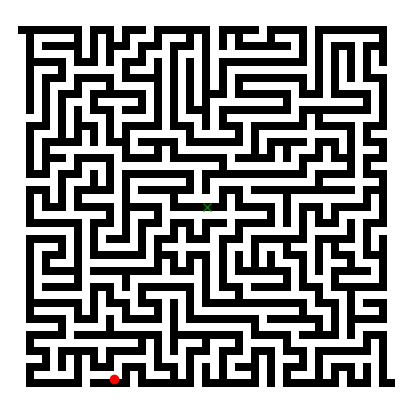

In [2]:
from maze_env import Maze
env = Maze(sparse=True)
env.plot()

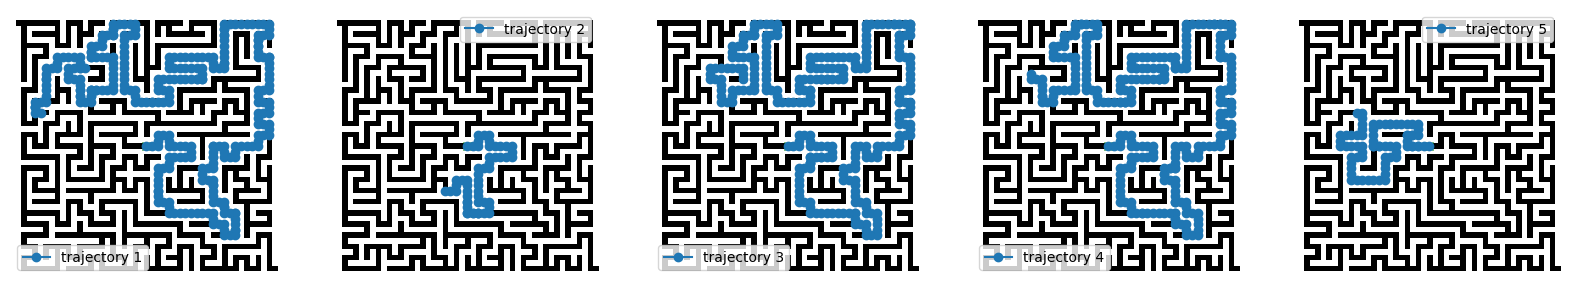

In [4]:
# load the trajectories
import pickle
with open(f'{folder}/../trajs.pkl','rb') as f:
    trajs = pickle.load(f)

num_plot = 5
fig, axs = plt.subplots(1, num_plot, figsize=(20,5))
# plot each state pair
for i in range(num_plot):
    # plot the first state
    axs[i].imshow(env.occ_map.T, origin="lower",extent=[0,env.Nx,0,env.Ny], cmap='gray')
    axs[i].plot(env.gx+0.5,env.gy+0.5,'gx') # goal location
    axs[i].plot(trajs[i][:,0]+0.5,trajs[i][:,1]+0.5, '-o',label=f'trajectory {i+1}')
    # finish up the rest of the plot settings
    axs[i].legend()
    axs[i].axis('off')
plt.show()

In [5]:
print("The length of the trajectory set is: " + str(len(trajs)))
print("The length of the first trajectory is: " + str(len(trajs[0])))

The length of the trajectory set is: 150
The length of the first trajectory is: 291


In [13]:
# manually create a dataset from the trajectories.
# the input is a pair of states, the output is the preference label: 0 if the first state is prefered, 1 if the second state is prefered.
# the preference is defined as the state whose index is larger in the trajectory.
# the state pairs are randomly samples from the same randomly chosen trajectory.

# the number of state pairs to sample
num_pairs = 100000
# the number of trajectories
num_traj = len(trajs)
# state length
state_len = len(trajs[0][0])
# noise in the preference assignment
noise = 0.0
# initialise dataset
traj_pairs = torch.zeros((num_pairs,2,length,state_len))
preferences = torch.zeros((num_pairs,1))

for i in range(num_pairs):
    if i % 10000 == 0:
        print(f"Generating sequence pair. Progress: {i+1}/{num_pairs}")
    # randomly choose a trajectory until a trajectory with length > 1 is found
    traj = trajs[np.random.randint(num_traj)]
    while len(traj) <= length:
        traj = trajs[np.random.randint(num_traj)]
    # randomly choose 2 different consecutive subsets from the trajectory
    idx1, idx2 = np.random.choice(len(traj)-length,2,replace=False)
    # idx1 and idx2 are the starting indices of the trajectory pairs
    s1 = traj[idx1] # sequence 1
    s2 = traj[idx2] # sequence 2
    for j in range(1,length):
        s1 = np.vstack((s1,traj[idx1+j]))
        s2 = np.vstack((s2,traj[idx2+j]))
    # assign the state pair to the state pair tensor
    traj_pairs[i,0] = torch.tensor(s1)
    traj_pairs[i,1] = torch.tensor(s2)
    # whichever state has the larger index is prefered, with some noise
    if np.random.rand() > noise:
        if idx1 > idx2:
            pref = 0
        else:
            pref = 1
    else:
        # randomly assign preference from 0 or 1
        pref = 0.5
    # assign the preference to the preference tensor
    preferences[i,0] = pref
    

Generating sequence pair. Progress: 1/100000
Generating sequence pair. Progress: 10001/100000
Generating sequence pair. Progress: 20001/100000
Generating sequence pair. Progress: 30001/100000
Generating sequence pair. Progress: 40001/100000
Generating sequence pair. Progress: 50001/100000
Generating sequence pair. Progress: 60001/100000
Generating sequence pair. Progress: 70001/100000
Generating sequence pair. Progress: 80001/100000
Generating sequence pair. Progress: 90001/100000


In [14]:
print("The shape of the sequence pairs are: \n" + str(traj_pairs.size()))
print("Example of a sequence pair: " + str(traj_pairs[0]))
print("")
print("The shape of the preferences are: \n" + str(preferences.size()))
print("The preferences are: " + str(preferences))


The shape of the sequence pairs are: 
torch.Size([100000, 2, 3, 2])
Example of a sequence pair: tensor([[[ 9., 23.],
         [10., 23.],
         [11., 23.]],

        [[12., 17.],
         [13., 17.],
         [14., 17.]]])

The shape of the preferences are: 
torch.Size([100000, 1])
The preferences are: tensor([[1.],
        [1.],
        [1.],
        ...,
        [0.],
        [0.],
        [0.]])


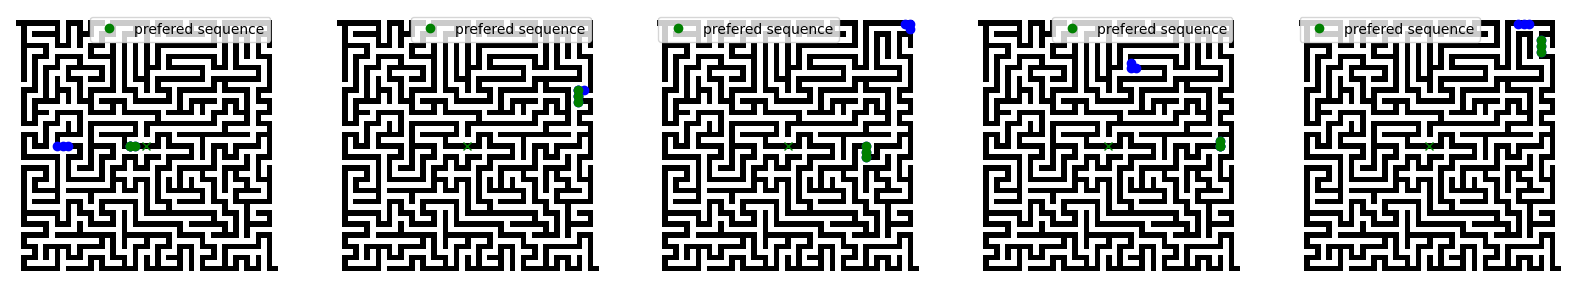

In [16]:
# select 5 random pairs of states, and colour the state that is prefered in green
num_plot = 5
# create subplots
fig, axs = plt.subplots(1, num_plot, figsize=(20,5))
# plot each state pair
for i in range(num_plot):
    # randomly choose a state pair
    idx = np.random.randint(num_pairs)
    s1 = traj_pairs[idx,0]
    s2 = traj_pairs[idx,1]
    p = preferences[idx,0]
    # plot the first state
    axs[i].imshow(env.occ_map.T, origin="lower",extent=[0,env.Nx,0,env.Ny], cmap='gray')
    axs[i].plot(env.gx+0.5,env.gy+0.5,'gx') # goal location
    axs[i].plot(s1[:,0]+0.5,s1[:,1]+0.5,'bo')
    # plot the second state
    axs[i].plot(s2[:,0]+0.5,s2[:,1]+0.5,'bo')
    # plot the prefered state in green
    if p == 0:
        axs[i].plot(s1[:,0]+0.5,s1[:,1]+0.5,'go', label='prefered sequence')
        #axs[i].plot(s2[0]+0.5,s2[1]+0.5,'bo')
        axs[i].legend()
    elif p == 1:
        #axs[i].plot(s1[0]+0.5,s1[1]+0.5,'bo')
        axs[i].plot(s2[:,0]+0.5,s2[:,1]+0.5,'go', label='prefered sequence')
        axs[i].legend()
    # finish up the rest of the plot settings
    axs[i].axis('off')
    plt.savefig(f"{folder}/sequence_pairs.png")

In [17]:
# save the dataset tensors into files
torch.save(traj_pairs, f'{folder}/sequence_pairs.pt')
torch.save(preferences, f'{folder}/preferences.pt')